In [1]:
from skimage.io import imread as imread
from skimage.io import imshow 
from scipy.ndimage.filters import convolve
from skimage.feature import match_template
from skimage.color import rgb2gray
import numpy as np
import matplotlib as pyplot
import random
def read(link):
    return np.array(imread(link))
A = imread('https://i.imgur.com/0IIZ6zI.jpg')
# Show the labyrinth we would like to find
imshow(A)

Start ligt op (306, 707) en end ligt op (339, 348)


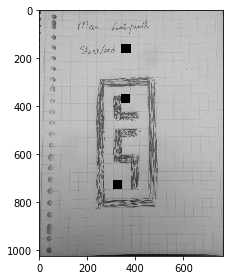

In [2]:
# Hardcode the way the start and end is drawn and use normalized 
# cross correlation to find this in the maze
imshow(A[140:180,340:380])
start_end = rgb2gray(A[140:180,340:380])
B = rgb2gray(A)
B[140:180,340:380] = 0
imshow(B)

result = match_template(B, start_end)
ij = np.unravel_index(np.argmax(result), result.shape)
start = ij[::-1]
B[start[1]:start[1]+start_end.shape[1], start[0]:start[0]+start_end.shape[0]] = 0
# Start is found
imshow(B)

result = match_template(B, start_end)
ij = np.unravel_index(np.argmax(result), result.shape)
end = ij[::-1]
B[end[1]:end[1]+start_end.shape[1], end[0]:end[0]+start_end.shape[0]] = 0
# Start is found
imshow(B)

print(f"Start ligt op {start} en end ligt op {end}")

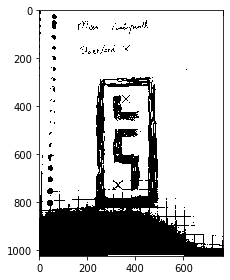

In [3]:
def make_boxblur(A):
    A = convolve(A, 1/9*np.ones((3,3)))
    return A

def make_gauss(A):
    A = convolve(A, 1/16*np.array([[1,2,1],[2,4,2],[1,2,1]]))
    return A

f = rgb2gray(A)
f = make_boxblur(f)
f = make_gauss(f)
# this is just the results of the convolutions
f[f > np.mean(f)*.9] = 0
f[f < np.mean(f)*.9] = 1
f[f != 1] = 0
imshow(f)

# Set a reward at the end of the image and a negative reward for the walls
f[f == 0] = -1000
f[end] = 500000

> De afbeelding is nu onderverdeeld in waardes van 1 en 0. En we hebben de het start en eind punt. Nu ga ik aangepaste versie van q learning gebruiken om van de start naar het eindpunt te komen. We nemen hiervoor stappen van 20 pixels, per pixel zou beter zijn, maar kost meer tijd om te berekenen.

In [4]:
def q_learning(maze, start, epsilon=.9, trials=100):
    route = np.zeros((*maze.shape, 4))
    steps = np.array([[-40, 0], [40,0], [0,40], [0,-40]])
    paths = []
    # train the q learning for x trials
    for i in range(trials):
        current = np.array(start)
        path = []
        reward = 0
        while reward >= 0:
            path.append(current)
            if random.random() >= epsilon:
                next_step = random.choice([i for i in enumerate(route[tuple(current)])])
            else:
                # take one of the random max values
                next_step = [i for i in enumerate(route[tuple(current)]) if i[1] == max(route[tuple(current)])]
                next_step = random.choice(next_step)
            try:
                reward = maze[tuple(current + steps[next_step[0]])]
            except IndexError:
                break
            route[current[0], current[1], next_step[0]] = reward
            current = current + steps[next_step[0]]
        paths.append(path)
    return paths, trials

# print(q_learning(f, start, 0.9, 200)[0])
b = q_learning(f, end, 0.9, 1000)[0]